In [50]:
import time
timestamp_start = time.time()

# Training
Train `Doc2Vec` on both the training and the test data building a word → document inverted index. The training data are diverse English data sets.

In [51]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer
import pickle
import gzip

TRAINING_FNAME="SemEval-2014_Task-3/data/training/paragraph2sentence.train.input.tsv"
OTHER_TRAINING_FNAMES=[]
TEST_FNAME="SemEval-2014_Task-3/data/test/paragraph2sentence.test.input.tsv"
TEST_GOLD_SCORE_FNAME="SemEval-2014_Task-3/keys/test/paragraph2sentence.test.gs.tsv"
NOTEBOOK_FNAME="untrained_cluster"
MODEL_FNAME="untrained"

debug_file = open(NOTEBOOK_FNAME + ".log", 'w')
def debug(message):
    print(message, end='')
    debug_file.write(message)
    debug_file.flush()

buffers = {} # buffer files into RAM
for fname in OTHER_TRAINING_FNAMES:
    debug("Reading %s into RAM..." % fname) # print progress
    buffer = []
    with open(fname) as f:
        for doc in f:
            buffer.append(doc)
    buffers[fname] = buffer
    debug(" DONE\n") # print progress

In [52]:
wnl = WordNetLemmatizer()
inverted_index_serials = {}

def preprocess_document(doc, tag):
    for serial, w in enumerate(simple_preprocess(doc)):
        lemma = wnl.lemmatize(w)
        if lemma not in inverted_index:
            inverted_index[lemma] = {}
        if tag not in inverted_index[lemma]:
            if lemma not in inverted_index_serials:
                inverted_index_serials[lemma] = 0
            inverted_index[lemma][tag] = inverted_index_serials[lemma]
            inverted_index_serials[lemma] = inverted_index_serials[lemma] + 1
        yield lemma
        
class DocumentIterator(object):
    def __init__(self):
        self.epoch_number = 1
    def __iter__(self):
        debug(" Epoch %d: " % self.epoch_number) # print progress
        self.epoch_number = self.epoch_number + 1
        with open(TRAINING_FNAME) as f:
            for row in f:
                cols = row.rstrip().split("\t")
                tags = ("training-" + cols[2] + "-paragraph", "training-" + cols[2] + "-sentence")
                yield TaggedDocument(words=list(preprocess_document(cols[0], tags[0])), tags=[tags[0]])
                yield TaggedDocument(words=list(preprocess_document(cols[1], tags[1])), tags=[tags[1]])
        doc_number = 1
        for fname in OTHER_TRAINING_FNAMES:
            debug(".") # print progress
            for doc in buffers[fname]:
                tag = str(doc_number)
                doc_number = doc_number + 1
                yield TaggedDocument(words=list(preprocess_document(doc, tag)), tags=[tag])
        with open(TEST_FNAME) as f:
            for row in f:
                cols = row.rstrip().split("\t")
                tags = ("test-" + cols[2] + "-paragraph", "test-" + cols[2] + "-sentence")
                yield TaggedDocument(words=list(preprocess_document(cols[0], tags[0])), tags=[tags[0]])
                yield TaggedDocument(words=list(preprocess_document(cols[1], tags[1])), tags=[tags[1]])

inverted_index_loaded = False
try:
    with gzip.open(NOTEBOOK_FNAME + ".index", "rb") as f: # (a) load the entire inverted index
        inverted_index = pickle.load(f)
    model = Doc2Vec.load(MODEL_FNAME + ".doc2vec")
    inverted_index_loaded = True
except IOError:
    try:
        with gzip.open(MODEL_FNAME + ".index", "rb") as f: # (b) load the partially constructed inverted index
            inverted_index = pickle.load(f)
            model = Doc2Vec.load(MODEL_FNAME + ".doc2vec")
    except IOError:
        inverted_index = {}
        model = Doc2Vec(DocumentIterator(), dm=1, iter=100, size=100, workers=16) # (c) construct the inverted index
        model.save(MODEL_FNAME + ".doc2vec") # persist the model
        with gzip.open(MODEL_FNAME + ".index", "wb") as f: # persist the partially constructed inverted index
            pickle.dump(inverted_index, f, protocol=2)

For each word $w$, cluster the normalized vectors of documents containing $w$ via $k$-means, where $k$ is the cardinality of $w$'s synset according to WordNet. Store the vectors of the $k$ cluster centroids inside the inverted index entry for $w$.

In [53]:
import numpy as np

def l2_normalize(vec):
    norm = np.linalg.norm(vec)
    if norm == 0:
        return vec
    else:
        return vec / norm

In [54]:
from nltk.corpus import wordnet
from sklearn.cluster import k_means
import math

if not inverted_index_loaded:
    for word, doc_tags in inverted_index.items():
        j = len(wordnet.synsets(word))
        if j > 0:
            j = round(math.log(j))
        k = min(j, len(doc_tags))
        if k < 2: # skip unambiguous words
            continue
        doc_vecs = [l2_normalize(model.docvecs[tag]) for tag in doc_tags if tag != "_centroid_vecs"]
        doc_tags["_centroid_vecs"], _, _ = k_means(doc_vecs, n_clusters=k)
    
#    with gzip.open(NOTEBOOK_FNAME + ".index", "wb") as f: # persist the inverted index
#        pickle.dump(inverted_index, f, protocol=2)

For each document $d$ and an occurance of word $w$ in $d$, label this occurance of $w$ with the index $i$, where $c_i$ is the centroid from $w$'s inverted index that minimizes the cosine distance between $c_i$ and $d$. Train `Doc2Vec` on the disambiguated training data.

In [55]:
import scipy.spatial

def cosine_similarity(vec1, vec2): # cosine similarity clamped to [0; 2]
    if np.linalg.norm(vec1) == 0 or np.linalg.norm(vec2) == 0:
        return 0
    else:
        return 2.0 - scipy.spatial.distance.cosine(vec1, vec2)

In [56]:
preprocessed_docs = {}
def preprocess_document(doc, tag):
    if tag in preprocessed_docs: # memoize processed documents
        return preprocessed_docs[tag]
    doc_vec = l2_normalize(model.docvecs[tag])
    preprocessed_doc = []
    for w in simple_preprocess(doc):
        lemma = wnl.lemmatize(w)
        if lemma in inverted_index and "_centroid_vecs" in inverted_index[lemma]:
            centroid_vecs = inverted_index[lemma]["_centroid_vecs"]
            max_similarity = {"similarity": 0.0, "index": 0}
            for index, centroid_vec in enumerate(centroid_vecs):
                similarity = cosine_similarity(doc_vec, centroid_vec)
                if similarity > max_similarity["similarity"]:
                    max_similarity["similarity"] = similarity
                    max_similarity["index"] = index
            preprocessed_doc.append(lemma + "-" + str(max_similarity["index"]))
        else:
            preprocessed_doc.append(lemma)
    preprocessed_docs[tag] = preprocessed_doc
    return preprocessed_doc
        
class DocumentIterator(object):
    def __init__(self):
        self.epoch_number = 1
    def __iter__(self):
        debug(" Epoch %d: " % self.epoch_number) # print progress
        self.epoch_number = self.epoch_number + 1
        with open(TRAINING_FNAME) as f:
            for row in f:
                cols = row.rstrip().split("\t")
                tags = ("training-" + cols[2] + "-paragraph", "training-" + cols[2] + "-sentence")
                yield TaggedDocument(words=list(preprocess_document(cols[0], tags[0])), tags=[tags[0]])
                yield TaggedDocument(words=list(preprocess_document(cols[1], tags[1])), tags=[tags[1]])
        doc_number = 1
        for fname in OTHER_TRAINING_FNAMES:
            debug(".") # print progress
            for doc in buffers[fname]:
                tag = str(doc_number)
                doc_number = doc_number + 1
                yield TaggedDocument(words=list(preprocess_document(doc, tag)), tags=[tag])
        with open(TEST_FNAME) as f:
            for row in f:
                cols = row.rstrip().split("\t")
                tags = ("test-" + cols[2] + "-paragraph", "test-" + cols[2] + "-sentence")
                yield TaggedDocument(words=list(preprocess_document(cols[0], tags[0])), tags=[tags[0]])
                yield TaggedDocument(words=list(preprocess_document(cols[1], tags[1])), tags=[tags[1]])

try:
    disambiguated_model = Doc2Vec.load(NOTEBOOK_FNAME + ".doc2vec")
except IOError:
    disambiguated_model = Doc2Vec(DocumentIterator(), dm=1, iter=100, size=100)
    disambiguated_model.save(NOTEBOOK_FNAME + ".doc2vec") # persist the model

 Epoch 1:  Epoch 2:  Epoch 3:  Epoch 4:  Epoch 5:  Epoch 6:  Epoch 7:  Epoch 8:  Epoch 9:  Epoch 10:  Epoch 11:  Epoch 12:  Epoch 13:  Epoch 14:  Epoch 15:  Epoch 16:  Epoch 17:  Epoch 18:  Epoch 19:  Epoch 20:  Epoch 21:  Epoch 22:  Epoch 23:  Epoch 24:  Epoch 25:  Epoch 26:  Epoch 27:  Epoch 28:  Epoch 29:  Epoch 30:  Epoch 31:  Epoch 32:  Epoch 33:  Epoch 34:  Epoch 35:  Epoch 36:  Epoch 37:  Epoch 38:  Epoch 39:  Epoch 40:  Epoch 41:  Epoch 42:  Epoch 43:  Epoch 44:  Epoch 45:  Epoch 46:  Epoch 47:  Epoch 48:  Epoch 49:  Epoch 50:  Epoch 51:  Epoch 52:  Epoch 53:  Epoch 54:  Epoch 55:  Epoch 56:  Epoch 57:  Epoch 58:  Epoch 59:  Epoch 60:  Epoch 61:  Epoch 62:  Epoch 63:  Epoch 64:  Epoch 65:  Epoch 66:  Epoch 67:  Epoch 68:  Epoch 69:  Epoch 70:  Epoch 71:  Epoch 72:  Epoch 73:  Epoch 74:  Epoch 75:  Epoch 76:  Epoch 77:  Epoch 78:  Epoch 79:  Epoch 80:  Epoch 81:  Epoch 82:  Epoch 83:  Epoch 84:  Epoch 85:  Epoch 86:  Epoch 87:  Epoch 88:  Epoch 89:  Epoch 90:  Epoch 91:  Epoch 9

# Testing
Compute the cosine similarity of the disambiguated document vectors of the testing paragraph-sentence pairs.

In [57]:
test_similarities = []
with open(TEST_FNAME) as f:
    for row in f:
        cols = row.rstrip().split("\t")
        tags = ("test-" + cols[2] + "-paragraph", "test-" + cols[2] + "-sentence")
        disambiguated_vec1 = disambiguated_model.docvecs[tags[0]]
        disambiguated_vec2 = disambiguated_model.docvecs[tags[1]]
        test_similarities.append(cosine_similarity(disambiguated_vec1, disambiguated_vec2) * 2.0)

Compare the similarities with the gold score.

<IPython.core.display.Javascript object>


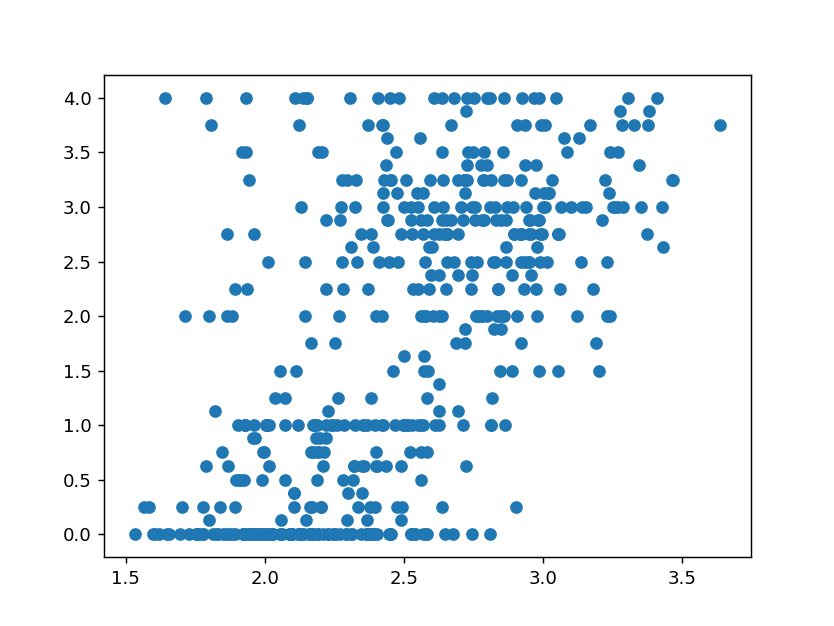

Pearson's correlation coefficient: 0.595225


In [58]:
%matplotlib notebook
import scipy.stats
import matplotlib.pyplot as plt

test_gold_similarities = []
with open(TEST_GOLD_SCORE_FNAME) as f:
    for line in f:
        test_gold_similarities.append(float(line))

plt.scatter(test_similarities, test_gold_similarities)
plt.show()
debug("Pearson's correlation coefficient: %f\n" % scipy.stats.pearsonr(test_similarities, test_gold_similarities)[0])

In [59]:
timestamp_end = time.time()
debug("Time elapsed: %d seconds\n" % (timestamp_end - timestamp_start))

Time elapsed: 46 seconds
